In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read in data
walmart = pd.read_csv('Data/task_4_2.csv', sep=",", header = 0)

In [103]:
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split,KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn_evaluation import plot

In [4]:
df_new = walmart.copy()
drop_col = ['wm_yr_wk','week_id', 'store_id', 
            'log_pct_change', 'price_CA', 'price_WI', 
            'price_TX', 'log_amzn_price', 'log_weekly_revenue', 
            'log_gas_price']
df_new.drop(drop_col, axis=1, inplace=True) 

In [5]:
X = df_new.drop('weekly_revenue', axis=1)
y = df_new['weekly_revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [6]:
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=101)
for depth in range(1,21):
    tree_regressor = tree.DecisionTreeRegressor(max_depth=depth, 
                                                random_state=101)
    if tree_regressor.fit(X_train,y_train).tree_.max_depth < depth:
        break
    score = np.mean(cross_val_score(tree_regressor, X_train, y_train, 
                                    scoring='neg_mean_absolute_percentage_error', 
                                    cv=crossvalidation, n_jobs=1))
    print(depth, score)

1 -0.24906011350494914
2 -0.19920393921049018
3 -0.16504821646306922
4 -0.13641496404468245
5 -0.11388808232782252
6 -0.09373426353751077
7 -0.08174301010368394
8 -0.07507107634681212
9 -0.07238981252785012
10 -0.07382391691400308
11 -0.07249109047197363
12 -0.0727116912610169
13 -0.07207286891379142
14 -0.07290794671965974
15 -0.07438505711976603
16 -0.07490253887041133
17 -0.07476460935651183
18 -0.07504064548426387
19 -0.07606510584776474
20 -0.07530090652348895


In [86]:
ada = AdaBoostRegressor()
search_grid_ada = {'n_estimators': [500, 1000, 2000],
               'learning_rate':[0.001, 0.01, 0.1],
               'random_state':[101]}
search_ada = GridSearchCV(estimator=ada, param_grid=search_grid_ada, 
                      scoring='neg_mean_absolute_percentage_error',
                      n_jobs=1, cv=crossvalidation)

In [92]:
search_ada.fit(X_train,y_train)
print(search_ada.best_params_)
print(search_ada.best_score_)

{'learning_rate': 0.001, 'n_estimators': 2000, 'random_state': 101}
-0.1593642379198679


In [93]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')


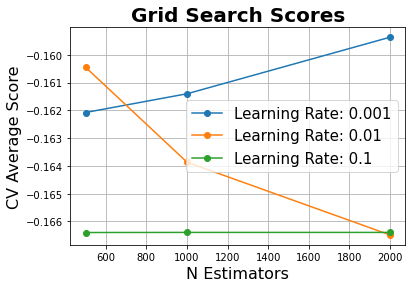

In [104]:
# Calling Method 
plot_grid_search(search_ada.cv_results_, search_grid_ada['n_estimators'], search_grid_ada['learning_rate'], 'N Estimators', 'Learning Rate')

<AxesSubplot:title={'center':'Grid search results'}, xlabel='n_estimators', ylabel='Mean score'>

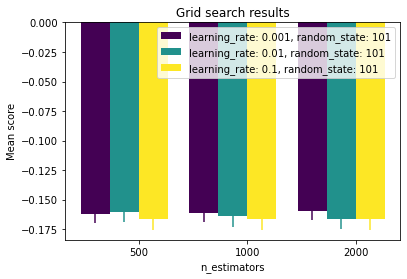

In [105]:
grid_scores_ada = search_ada.cv_results_
plot.grid_search(grid_scores_ada, change='n_estimators',kind='bar')

In [9]:
ada2 = AdaBoostRegressor(n_estimators=2000, 
                         learning_rate=0.01, 
                         random_state=101)
score_ada = np.mean(cross_val_score(ada2, X_train, y_train, 
                                scoring='neg_mean_absolute_percentage_error',
                                cv=crossvalidation, n_jobs=1))
print(score_ada)

-0.16648510916771114


In [10]:
ada2.fit(X_train, y_train.values.ravel())

AdaBoostRegressor(learning_rate=0.01, n_estimators=2000, random_state=101)

In [11]:
y_pred_train_ada = ada2.predict(X_train)
y_pred_test_ada = ada2.predict(X_test)

In [12]:
mape_train_ada = mean_absolute_percentage_error(y_train, y_pred_train_ada)
mape_test_ada = mean_absolute_percentage_error(y_test, y_pred_test_ada)
print(mape_train_ada, mape_test_ada)

0.1647484514760176 0.16786103975864747


#### GBM

In [106]:
gbm = GradientBoostingRegressor()
search_grid_gbm = {'n_estimators': [500, 1000, 2000],
               'learning_rate':[0.001, 0.01, 0.1],
               'max_depth':[1,2,4],
               'subsample':[0.5,0.75,1],
               'random_state':[101]}
search_gbm = GridSearchCV(estimator=gbm, param_grid=search_grid_gbm, 
                      scoring='neg_mean_absolute_percentage_error',
                      n_jobs=1, cv=crossvalidation)

In [107]:
search_gbm.fit(X_train,y_train)
print(search_gbm.best_params_)
print(search_gbm.best_score_)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 2000, 'random_state': 101, 'subsample': 0.75}
-0.051782353669697176


<AxesSubplot:>

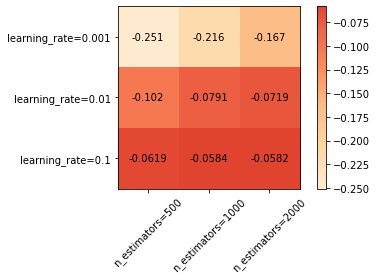

In [127]:
plot.grid_search(search_gbm.cv_results_, change=('n_estimators', 'learning_rate'),
                 subset={'max_depth': 2,
                         'subsample':1,
                         'random_state':[101]},
                 )

<AxesSubplot:>

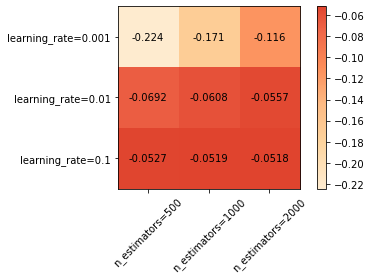

In [128]:
plot.grid_search(search_gbm.cv_results_, change=('n_estimators', 'learning_rate'),
                 subset={'max_depth': 4,
                         'subsample':1,
                         'random_state':[101]},
                 )

<AxesSubplot:>

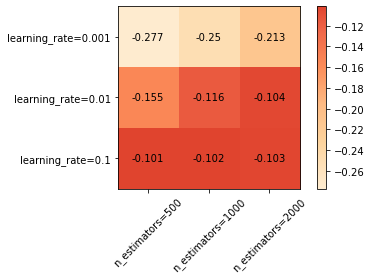

In [129]:
plot.grid_search(search_gbm.cv_results_, change=('n_estimators', 'learning_rate'),
                 subset={'max_depth': 1,
                         'subsample':0.75,
                         'random_state':[101]},
                 )

<AxesSubplot:>

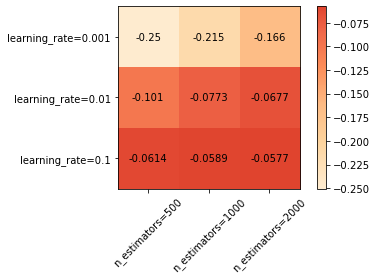

In [130]:
plot.grid_search(search_gbm.cv_results_, change=('n_estimators', 'learning_rate'),
                 subset={'max_depth': 2,
                         'subsample':0.75,
                         'random_state':[101]},
                 )

<AxesSubplot:>

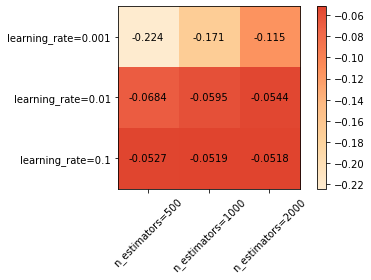

In [131]:
plot.grid_search(search_gbm.cv_results_, change=('n_estimators', 'learning_rate'),
                 subset={'max_depth': 4,
                         'subsample':0.75,
                         'random_state':[101]},
                 )

<AxesSubplot:>

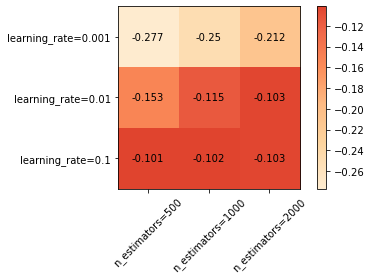

In [132]:
plot.grid_search(search_gbm.cv_results_, change=('n_estimators', 'learning_rate'),
                 subset={'max_depth': 1,
                         'subsample':0.5,
                         'random_state':[101]},
                 )

<AxesSubplot:>

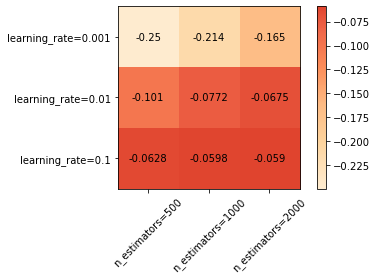

In [133]:
plot.grid_search(search_gbm.cv_results_, change=('n_estimators', 'learning_rate'),
                 subset={'max_depth': 2,
                         'subsample':0.5,
                         'random_state':[101]},
                 )

<AxesSubplot:>

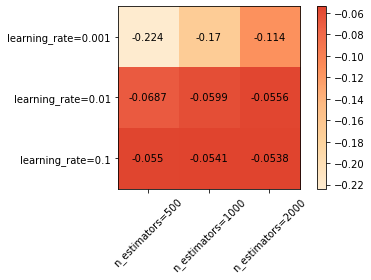

In [134]:
plot.grid_search(search_gbm.cv_results_, change=('n_estimators', 'learning_rate'),
                 subset={'max_depth': 4,
                         'subsample':0.5,
                         'random_state':[101]},
                 )

In [15]:
gbm2 = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.1,
                                 max_depth=4, subsample=0.75, random_state=101)
score_gbm = np.mean(cross_val_score(gbm2, X_train, y_train, 
                                scoring='neg_mean_absolute_percentage_error',
                                cv=crossvalidation, n_jobs=1))
print(score_gbm)

-0.051782353669697176


In [16]:
gbm2.fit(X_train, y_train.values.ravel())

GradientBoostingRegressor(max_depth=4, n_estimators=2000, random_state=101,
                          subsample=0.75)

In [17]:
y_pred_train_gbm = gbm2.predict(X_train)
y_pred_test_gbm = gbm2.predict(X_test)
mape_train_gbm = mean_absolute_percentage_error(y_train, y_pred_train_gbm)
mape_test_gbm = mean_absolute_percentage_error(y_test, y_pred_test_gbm)
print(mape_train_gbm, mape_test_gbm)

0.0029935065003578775 0.050497519004005426


#### Elastic Net

In [18]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred_train_lin = reg.predict(X_train)
y_pred_test_lin = reg.predict(X_test)
mape_train_lin = mean_absolute_percentage_error(y_train, y_pred_train_lin)
mape_test_lin = mean_absolute_percentage_error(y_test, y_pred_test_lin)
print(mape_train_lin,mape_test_lin)

0.10901684302077608 0.1139491891262956


In [19]:
coef_dict_lin = {}
for coef, feat in zip(reg.coef_, X_train.columns):
    coef_dict_lin[feat] = coef
coef_dict_lin

{'Cultural': 524.3867258129565,
 'Sporting': 3289.368078375619,
 'National': -2123.1806166852834,
 'Religious': 373.061398699978,
 'pct_change_price': 129.41812673919384,
 'store_id_CA_1': 12731.294561269397,
 'store_id_CA_2': -1778.8328477073262,
 'store_id_CA_3': 47811.95281540627,
 'store_id_CA_4': -24048.87938247667,
 'store_id_TX_1': -11678.155992776286,
 'store_id_TX_2': 5618.180022996599,
 'store_id_TX_3': -3805.7067296309447,
 'store_id_WI_1': -13100.942898424993,
 'store_id_WI_2': -3595.3648398305722,
 'store_id_WI_3': -8153.54470882544,
 'amzn_price': 401.22182187894316,
 'gas_price': 357.8930449829544,
 'item_on': 17.406673020358767}

When the l1_ratio is set to 0, it is the same as ridge regression.
When the l1_ratio is set to 1, it is the same as LASSO.
Elastic Net is somewhere in between.

In [109]:
ELN = ElasticNet(normalize=True)
search_ELN = GridSearchCV(estimator=ELN, 
                         param_grid={'alpha': np.logspace(-5, 2, 8),
                                    'l1_ratio': [0.1,0.2,0.3,0.4,0.5,
                                                 0.6,0.7,0.8,0.9]},
                         scoring = 'neg_mean_absolute_percentage_error',
                         n_jobs=1, refit=True, cv=10)

In [110]:
search_ELN.fit(X_train, y_train)


C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did n

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did n

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did n

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.685e+10, tolerance: 9.772e+07
  model = cd_fast.enet_coordinate_descent(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X,

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in vers

GridSearchCV(cv=10, estimator=ElasticNet(normalize=True), n_jobs=1,
             param_grid={'alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9]},
             scoring='neg_mean_absolute_percentage_error')

In [111]:
print(search_ELN.best_params_)
print(search_ELN.best_score_)

{'alpha': 0.0001, 'l1_ratio': 0.9}
-0.10993621534539186


<AxesSubplot:title={'center':'Grid search results'}, xlabel='l1_ratio', ylabel='Mean score'>

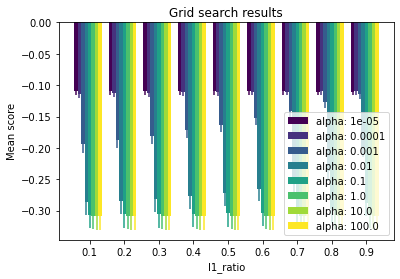

In [113]:
grid_scores_eln = search_ELN.cv_results_
plot.grid_search(grid_scores_eln, change='l1_ratio',kind='bar')

In [23]:
ELN2 = ElasticNet(normalize=True, alpha=0.0001, l1_ratio=0.9)
ELN2.fit(X_train,y_train)

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(


ElasticNet(alpha=0.0001, l1_ratio=0.9, normalize=True)

In [24]:
y_pred_train_eln = ELN2.predict(X_train)
y_pred_test_eln = ELN2.predict(X_test)
mape_train_eln = mean_absolute_percentage_error(y_train, y_pred_train_eln)
mape_test_eln = mean_absolute_percentage_error(y_test, y_pred_test_eln)
print(mape_train_eln,mape_test_eln)

0.10891353463796612 0.11376450569670139


In [54]:
coef_dict_eln = {}
for coef, feat in zip(ELN2.coef_, X_train.columns):
    coef_dict_eln[feat] = coef
coef_dict_eln

{'Cultural': 514.4476059172689,
 'Sporting': 3219.851159597493,
 'National': -2094.8407774516504,
 'Religious': 374.6483848801328,
 'pct_change_price': 141.19324427481698,
 'store_id_CA_1': 12670.30923562793,
 'store_id_CA_2': -1729.1129413908925,
 'store_id_CA_3': 47158.24220682081,
 'store_id_CA_4': -23523.32778093716,
 'store_id_TX_1': -11312.840908632616,
 'store_id_TX_2': 5696.5962430388445,
 'store_id_TX_3': -3584.3862712208966,
 'store_id_WI_1': -12783.044150174583,
 'store_id_WI_2': -3398.3650280193187,
 'store_id_WI_3': -7833.249769566098,
 'amzn_price': 439.5309096210732,
 'gas_price': 366.33760323404425,
 'item_on': 16.74875964809194}

### Work on evaluation set

In [59]:
# Read in evaluation data
eval_df = pd.read_csv('Data/task_5.csv', sep=",", header = 0)
eval_df.head()

,wm_yr_wk,store_id,week_id,Cultural,Sporting,National,Religious,weekly_revenue,pct_change_price,log_pct_change,...,store_id_WI_3,price_CA,price_WI,price_TX,amzn_price,gas_price,log_amzn_price,log_weekly_revenue,log_gas_price,item_on
0,11614,CA_1,275,1,0,0,1,111473.48,-0.023101,-1.468426,...,0,2.779667,2.124,1.937333,33.591099,2.779667,3.514261,11.621542,1.022331,3049
1,11614,CA_2,275,1,0,0,1,110671.45,0.053453,-1.181424,...,0,2.779667,2.124,1.937333,33.591099,2.779667,3.514261,11.614321,1.022331,3049
2,11614,CA_3,275,1,0,0,1,153107.45,0.097569,-1.047090,...,0,2.779667,2.124,1.937333,33.591099,2.779667,3.514261,11.938895,1.022331,3049
3,11614,CA_4,275,1,0,0,1,65648.12,-0.001763,-1.379815,...,0,2.779667,2.124,1.937333,33.591099,2.779667,3.514261,11.092064,1.022331,3049
4,11614,TX_1,275,1,0,0,1,75887.06,0.051465,-1.187924,...,0,2.779667,2.124,1.937333,33.591099,1.937333,3.514261,11.237001,0.661312,3049


In [60]:
eval_new = eval_df.copy()

# Subset to variables that seem appropriate - variables considered in linear regression
# Variables - week_id, store_id, log_pct_change, store_id_WI_3, price_CA, price_WI, price_TX, gas_price, log_amzn_price, log_weekly_revenue
drop_col = ['wm_yr_wk','week_id', 'store_id', 'log_pct_change', 'price_CA', 'price_WI', 'price_TX', 'log_amzn_price', 'log_weekly_revenue', 'log_gas_price']
eval_new.drop(drop_col, axis=1, inplace=True) # dropping columns

eval_new.head()

,Cultural,Sporting,National,Religious,weekly_revenue,pct_change_price,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,amzn_price,gas_price,item_on
0,1,0,0,1,111473.48,-0.023101,1,0,0,0,0,0,0,0,0,0,33.591099,2.779667,3049
1,1,0,0,1,110671.45,0.053453,0,1,0,0,0,0,0,0,0,0,33.591099,2.779667,3049
2,1,0,0,1,153107.45,0.097569,0,0,1,0,0,0,0,0,0,0,33.591099,2.779667,3049
3,1,0,0,1,65648.12,-0.001763,0,0,0,1,0,0,0,0,0,0,33.591099,2.779667,3049
4,1,0,0,1,75887.06,0.051465,0,0,0,0,1,0,0,0,0,0,33.591099,1.937333,3049


In [61]:
X_eval = eval_new.drop('weekly_revenue', axis = 1)
y_eval = eval_new['weekly_revenue']

In [62]:
y_pred_eval_ada = ada2.predict(X_eval)
mape_eval_ada = mean_absolute_percentage_error(y_eval, y_pred_eval_ada)
print(mape_eval_ada)

0.519656515041001


In [63]:
df_eval = pd.DataFrame({'y_pred_eval_ada':y_pred_eval_ada})
df_eval= pd.concat([eval_df[['weekly_revenue','week_id']], df_eval], axis=1)
df_eval.head()

,weekly_revenue,week_id,y_pred_eval_ada
0,111473.48,275,82110.448795
1,110671.45,275,81509.532774
2,153107.45,275,134048.899429
3,65648.12,275,72416.061843
4,75887.06,275,81081.491908


In [64]:
df_eval['error_ada'] = abs((df_eval['weekly_revenue'] - df_eval['y_pred_eval_ada'])/df_eval['weekly_revenue'])
df_eval.head()

,weekly_revenue,week_id,y_pred_eval_ada,error_ada
0,111473.48,275,82110.448795,0.263408
1,110671.45,275,81509.532774,0.263500
2,153107.45,275,134048.899429,0.124478
3,65648.12,275,72416.061843,0.103094
4,75887.06,275,81081.491908,0.068450


In [65]:
y_pred_eval_gbm = gbm2.predict(X_eval)
mape_eval_gbm = mean_absolute_percentage_error(y_eval, y_pred_eval_gbm)
print(mape_eval_gbm)

0.4790598914782266


In [66]:
df_eval= pd.concat([df_eval, pd.DataFrame({'y_pred_eval_gbm':y_pred_eval_gbm})], axis=1)
df_eval['error_gbm'] = abs((df_eval['weekly_revenue'] - df_eval['y_pred_eval_gbm'])/df_eval['weekly_revenue'])
df_eval.head()

,weekly_revenue,week_id,y_pred_eval_ada,error_ada,y_pred_eval_gbm,error_gbm
0,111473.48,275,82110.448795,0.263408,98208.008556,0.119001
1,110671.45,275,81509.532774,0.263500,90444.496172,0.182766
2,153107.45,275,134048.899429,0.124478,124637.259501,0.185949
3,65648.12,275,72416.061843,0.103094,54055.237102,0.176591
4,75887.06,275,81081.491908,0.068450,68471.657615,0.097716


In [67]:
y_pred_eval_eln = ELN2.predict(X_eval)
mape_eval_eln = mean_absolute_percentage_error(y_eval, y_pred_eval_eln)
print(mape_eval_eln)

0.49173095613271645


In [68]:
df_eval= pd.concat([df_eval, pd.DataFrame({'y_pred_eval_eln':y_pred_eval_eln})], axis=1)
df_eval['error_eln'] = abs((df_eval['weekly_revenue'] - df_eval['y_pred_eval_eln'])/df_eval['weekly_revenue'])
df_eval.head()

,weekly_revenue,week_id,y_pred_eval_ada,error_ada,y_pred_eval_gbm,error_gbm,y_pred_eval_eln,error_eln
0,111473.48,275,82110.448795,0.263408,98208.008556,0.119001,100291.465890,0.100311
1,110671.45,275,81509.532774,0.263500,90444.496172,0.182766,85902.852571,0.223803
2,153107.45,275,134048.899429,0.124478,124637.259501,0.185949,134796.436639,0.119596
3,65648.12,275,72416.061843,0.103094,54055.237102,0.176591,64100.841568,0.023569
4,75887.06,275,81081.491908,0.068450,68471.657615,0.097716,76010.265552,0.001624


In [69]:
df_eval.groupby('week_id').mean()

,weekly_revenue,y_pred_eval_ada,error_ada,y_pred_eval_gbm,error_gbm,y_pred_eval_eln,error_eln
week_id,,,,,,,
275,99577.238,87198.876466,0.140992,84578.944142,0.147288,87601.747831,0.110032
276,98888.575,87198.040630,0.135906,85305.681182,0.131609,87964.037808,0.100512
277,98874.169,87201.509741,0.128825,84790.339023,0.142479,87363.893291,0.109626
278,33769.307,87198.040630,1.672903,83572.714303,1.494864,87523.163696,1.646754


Adaboost retrain

In [70]:
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=101)
for depth in range(1,21):
    tree_regressor = tree.DecisionTreeRegressor(max_depth=depth, 
                                                random_state=101)
    if tree_regressor.fit(X,y).tree_.max_depth < depth:
        break
    score = np.mean(cross_val_score(tree_regressor, X_train, y_train, 
                                    scoring='neg_mean_absolute_percentage_error', 
                                    cv=crossvalidation, n_jobs=1))
    print(depth, score)

1 -0.24906011350494914
2 -0.19920393921049018
3 -0.16504821646306922
4 -0.13641496404468245
5 -0.11388808232782252
6 -0.09373426353751077
7 -0.08174301010368394
8 -0.07507107634681212
9 -0.07238981252785012
10 -0.07382391691400308
11 -0.07249109047197363
12 -0.0727116912610169
13 -0.07207286891379142
14 -0.07290794671965974
15 -0.07438505711976603
16 -0.07490253887041133
17 -0.07476460935651183
18 -0.07504064548426387
19 -0.07606510584776474
20 -0.07530090652348895


search_ada.fit(X,y)
print(search_ada.best_params_)
print(search_ada.best_score_)

In [71]:
ada3 = AdaBoostRegressor(n_estimators=2000, 
                         learning_rate=0.01, 
                         random_state=101)
score_ada = np.mean(cross_val_score(ada3, X, y, 
                                scoring='neg_mean_absolute_percentage_error',
                                cv=crossvalidation, n_jobs=1))
print(score_ada)

-0.16712045594868458


In [72]:
ada3.fit(X, y.values.ravel())
y_pred_all_ada = ada3.predict(X)
y_pred_eval_ada = ada3.predict(X_eval)
mape_all_ada = mean_absolute_percentage_error(y, y_pred_all_ada)
mape_eval_ada = mean_absolute_percentage_error(y_eval, y_pred_eval_ada)
print(mape_all_ada, mape_eval_ada)

0.16493589839717707 0.5267249928886957


In [73]:
df_eval = pd.DataFrame({'y_pred_eval_ada':y_pred_eval_ada})
df_eval= pd.concat([eval_df[['weekly_revenue','week_id']], df_eval], axis=1)
df_eval.head()

,weekly_revenue,week_id,y_pred_eval_ada
0,111473.48,275,82453.425831
1,110671.45,275,81644.819872
2,153107.45,275,134943.190449
3,65648.12,275,75222.792764
4,75887.06,275,81258.188434


In [74]:
df_eval['error_ada'] = abs((df_eval['weekly_revenue'] - df_eval['y_pred_eval_ada'])/df_eval['weekly_revenue'])
df_eval.head()

,weekly_revenue,week_id,y_pred_eval_ada,error_ada
0,111473.48,275,82453.425831,0.260331
1,110671.45,275,81644.819872,0.262277
2,153107.45,275,134943.190449,0.118637
3,65648.12,275,75222.792764,0.145848
4,75887.06,275,81258.188434,0.070778


gbm retrain

search_gbm.fit(X,y)
print(search_gbm.best_params_)
print(search_gbm.best_score_)

In [75]:
gbm3 = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.1,
                                 max_depth=4, subsample=0.75, random_state=101)
score_gbm = np.mean(cross_val_score(gbm3, X, y, 
                                scoring='neg_mean_absolute_percentage_error',
                                cv=crossvalidation, n_jobs=1))
print(score_gbm)

-0.04743119022684747


In [76]:
gbm3.fit(X, y.values.ravel())
y_pred_all_gbm = gbm3.predict(X)
y_pred_eval_gbm = gbm3.predict(X_eval)
mape_all_gbm = mean_absolute_percentage_error(y, y_pred_all_gbm)
mape_eval_gbm = mean_absolute_percentage_error(y_eval, y_pred_eval_gbm)
print(mape_all_gbm, mape_eval_gbm)

0.005440979513518111 0.46849311262757815


In [77]:
df_eval= pd.concat([df_eval, pd.DataFrame({'y_pred_eval_gbm':y_pred_eval_gbm})], axis=1)
df_eval['error_gbm'] = abs((df_eval['weekly_revenue'] - df_eval['y_pred_eval_gbm'])/df_eval['weekly_revenue'])
df_eval.head()

,weekly_revenue,week_id,y_pred_eval_ada,error_ada,y_pred_eval_gbm,error_gbm
0,111473.48,275,82453.425831,0.260331,96115.605665,0.137772
1,110671.45,275,81644.819872,0.262277,93506.535263,0.155098
2,153107.45,275,134943.190449,0.118637,129389.999510,0.154907
3,65648.12,275,75222.792764,0.145848,57401.894336,0.125613
4,75887.06,275,81258.188434,0.070778,68226.608848,0.100945


ELN retrain

search_ELN.fit(X, y)

print(search_ELN.best_params_)
print(search_ELN.best_score_)

In [78]:
ELN3 = ElasticNet(normalize=True, alpha=0.0001, l1_ratio=0.9)
ELN3.fit(X,y)

C:\Users\YizhiZhang\anaconda3\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(


ElasticNet(alpha=0.0001, l1_ratio=0.9, normalize=True)

In [79]:
y_pred_all_eln = ELN3.predict(X)
y_pred_eval_eln = ELN3.predict(X_eval)
mape_all_eln = mean_absolute_percentage_error(y, y_pred_all_eln)
mape_eval_eln = mean_absolute_percentage_error(y_eval, y_pred_eval_eln)
print(mape_all_eln,mape_eval_eln)

0.11004053331969062 0.4930570345671354


In [80]:
coef_dict_eln = {}
for coef, feat in zip(ELN3.coef_, X_train.columns):
    coef_dict_eln[feat] = coef
coef_dict_lin

{'Cultural': 514.4476059172689,
 'Sporting': 3219.851159597493,
 'National': -2094.8407774516504,
 'Religious': 374.6483848801328,
 'pct_change_price': 141.19324427481698,
 'store_id_CA_1': 12670.30923562793,
 'store_id_CA_2': -1729.1129413908925,
 'store_id_CA_3': 47158.24220682081,
 'store_id_CA_4': -23523.32778093716,
 'store_id_TX_1': -11312.840908632616,
 'store_id_TX_2': 5696.5962430388445,
 'store_id_TX_3': -3584.3862712208966,
 'store_id_WI_1': -12783.044150174583,
 'store_id_WI_2': -3398.3650280193187,
 'store_id_WI_3': -7833.249769566098,
 'amzn_price': 439.5309096210732,
 'gas_price': 366.33760323404425,
 'item_on': 16.74875964809194}

In [81]:
df_eval= pd.concat([df_eval, pd.DataFrame({'y_pred_eval_eln':y_pred_eval_eln})], axis=1)
df_eval['error_eln'] = abs((df_eval['weekly_revenue'] - df_eval['y_pred_eval_eln'])/df_eval['weekly_revenue'])
df_eval.head()

,weekly_revenue,week_id,y_pred_eval_ada,error_ada,y_pred_eval_gbm,error_gbm,y_pred_eval_eln,error_eln
0,111473.48,275,82453.425831,0.260331,96115.605665,0.137772,99865.123659,0.104136
1,110671.45,275,81644.819872,0.262277,93506.535263,0.155098,85178.982630,0.230344
2,153107.45,275,134943.190449,0.118637,129389.999510,0.154907,134351.972795,0.122499
3,65648.12,275,75222.792764,0.145848,57401.894336,0.125613,64166.885062,0.022563
4,75887.06,275,81258.188434,0.070778,68226.608848,0.100945,75580.370827,0.004041


In [82]:
df_eval.groupby('week_id').mean()

,weekly_revenue,y_pred_eval_ada,error_ada,y_pred_eval_gbm,error_gbm,y_pred_eval_eln,error_eln
week_id,,,,,,,
275,99577.238,87774.747153,0.143352,85010.385103,0.144953,87329.339908,0.112264
276,98888.575,87774.747153,0.138395,87554.619437,0.112406,87471.620270,0.104962
277,98874.169,87774.747153,0.131083,86577.540766,0.128862,87300.829024,0.109952
278,33769.307,87774.747153,1.694070,83653.824119,1.487752,87418.481929,1.645050
